In [5]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
from dataloader import *
from train_eval_test import *
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
import csv

## Load data

In [6]:
traffic_data = pd.read_csv('data/traffic.csv', header=None).to_numpy()

In [7]:
batch_size = 32
n_train = 12185
n_eval = 1757
n_test = 3509
train_loader, eval_loader, test_loader = get_loaders(traffic_data, batch_size, n_train, n_eval, n_test, T=96, S=96)

## Modèle

In [8]:
class Embedding_inverted(nn.Module):
    def __init__(self, T, D):
        super(Embedding_inverted, self).__init__()
        self.emb = nn.Linear(T, D)
        self.dropout = nn.Dropout(0.1)
    
    def forward(self, x):
        x = x.permute(0,2,1)
        x_emb = self.emb(x)
        return self.dropout(x_emb)

class FeedForward(nn.Module):
    def __init__(self, D):
        super(FeedForward, self).__init__()
        self.feed_forward = nn.Sequential(
          nn.Linear(D, D),
          nn.ReLU(),
          nn.Dropout(0.1),
          nn.Linear(D, D), 
        )

    def forward(self, x):
        #x = x.permute(0,2,1)
        x = self.feed_forward(x)
        #x = x.permute(0,2,1)
        return x
    
class Attention(nn.Module):
    def __init__(self, D, proj_dim, nb_head=8):
        super(Attention, self).__init__()
        self.query_projection = nn.Linear(D, proj_dim)
        self.key_projection = nn.Linear(D, proj_dim)
        self.value_projection = nn.Linear(D, proj_dim)
        self.out_projection = nn.Linear(proj_dim, D)
        self.H = nb_head

    def forward(self, queries, keys, values):
        B, L, _ = queries.shape
        _, S, _ = keys.shape
        H = self.H

        queries = self.query_projection(queries).view(B, L, H, -1)
        keys = self.key_projection(keys).view(B, S, H, -1)
        values = self.value_projection(values).view(B, S, H, -1)

        B, L, H, E = queries.shape
        _, S, _, D = values.shape
        scale = 1. / torch.sqrt(torch.tensor(E))

        scores = torch.einsum("blhe,bshe->bhls", queries, keys)
        A = torch.softmax(scale * scores, dim=-1)
        V = torch.einsum("bhls,bshd->blhd", A, values)

        out = V.reshape(B,L,-1)

        return self.out_projection(out)
        

class TrmBlock(nn.Module):
    def __init__(self, N, D, proj_dim):
      super(TrmBlock, self).__init__()

      self.multivariate_attention= Attention(D, proj_dim)
      self.layer_norm1 = nn.LayerNorm(D)
      self.feed_forward = FeedForward(D)
      self.layer_norm2 = nn.LayerNorm(D)

    def forward(self, x):
      att = self.multivariate_attention(x,x,x)
      x = self.layer_norm1(x + att)
      #print("x_norm  : ", x.shape)
      #print("permute : ", xT.shape)
      x_forward = self.feed_forward(x)
      x= self.layer_norm2(x + x_forward)
      return x


class iTransformer(nn.Module):
    def __init__(self, N, T, D, S, proj_dim, num_blocks):
      super(iTransformer, self).__init__()

      self.embedding = Embedding_inverted(T, D)
      self.trmblock = nn.ModuleList([TrmBlock(N, D, proj_dim) for _ in range(num_blocks)])
      self.projection = nn.Linear(D, S, bias=True)


    def forward(self, x):
      #print("x : ",x.shape)
      x = self.embedding(x)
      #print('emb : ',x.shape)
      for block in self.trmblock:
            x = block(x)
      #print('trmblock : ',x.shape)
      y = self.projection(x)
      #print('proj : ', y.shape)
      y=y.permute(0,2,1)
      #print('final : ', y.shape)
      return y

## Train 

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
#writer = SummaryWriter()

cuda


In [10]:
N = 862 #nb variables
T = 96 #input length (lookback window)
D = 512 # 256 ou 512
S = 96 # 96 ou 192, 336, 720
proj_dim = 128
#hidden_dim = 176 #dimension latente dans le feed forward du transformer 
num_blocks = 4 #2 ou 3 ou 4 (nombre de block de transformer)

itransformer = iTransformer(N, T, D, S, proj_dim, num_blocks).to(device)
optimizer = torch.optim.Adam(itransformer.parameters(), lr=1e-3) #10−3, 5 × 10−4, 10−4 



In [11]:
loss_values, loss_eval = train(itransformer, optimizer, train_loader, eval_loader, 10, device)

---- epoch :  0
loss train : 0.3258798067172368
loss eval : 0.5139612184495342
---- epoch :  1
loss train : 0.26955661495526634
loss eval : 0.48823560074884065
---- epoch :  2
loss train : 0.25951974622408547
loss eval : 0.48254603329969914
---- epoch :  3
loss train : 0.2540469752550125
loss eval : 0.47545998923632565
---- epoch :  4
loss train : 0.24851424276828765
loss eval : 0.46871198865832114
---- epoch :  5
loss train : 0.2460875231027603
loss eval : 0.4634423158606704
---- epoch :  6
loss train : 0.24827236131827038
loss eval : 0.45862170932244284
---- epoch :  7
loss train : 0.2407337582508723
loss eval : 0.44954377169511756
---- epoch :  8
loss train : 0.2384976159731547
loss eval : 0.4496548181893874
---- epoch :  9
loss train : 0.2356718575557073
loss eval : 0.44046433604493435


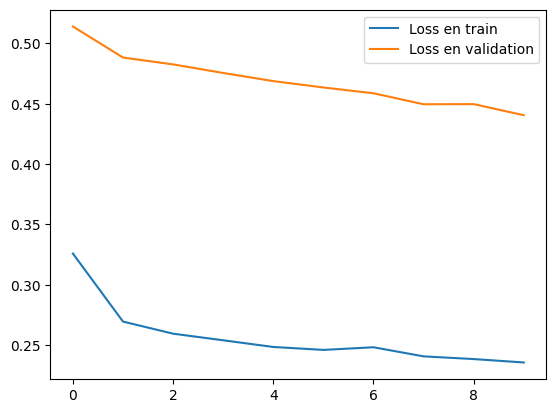

In [12]:
plt.figure()
plt.plot(loss_values,label="Loss en train")
plt.plot(loss_eval,label="Loss en validation")
plt.legend()
plt.show()

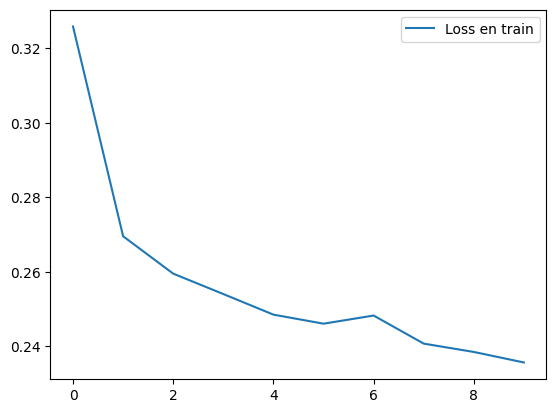

In [13]:
plt.figure()
plt.plot(loss_values,label="Loss en train")
plt.legend()
plt.show()

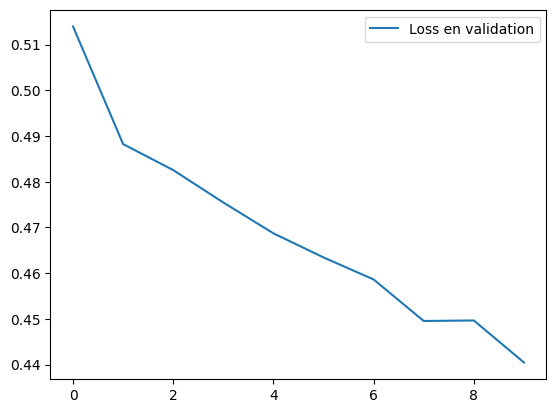

In [14]:
plt.figure()
plt.plot(loss_eval,label="Loss en validation")
plt.legend()
plt.show()

## Test

In [15]:
loss_test, target, yhat = test(itransformer, test_loader, device)

print("MSE : ", loss_test)

MSE :  0.5605344940530191


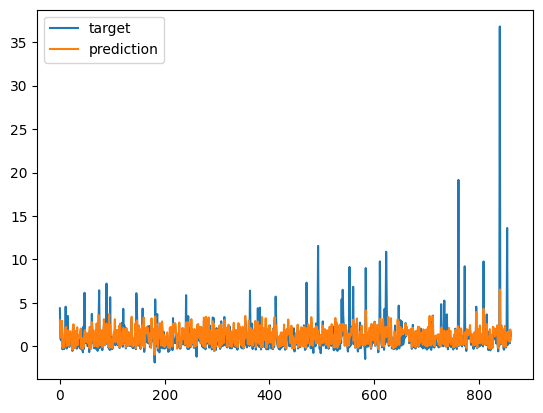

In [22]:
i = 1
plt.figure()
plt.plot(target[0][:][i].to("cpu"),label="target")
plt.plot(yhat[0][:][i].to("cpu"),label="prediction")
plt.legend()
plt.show()


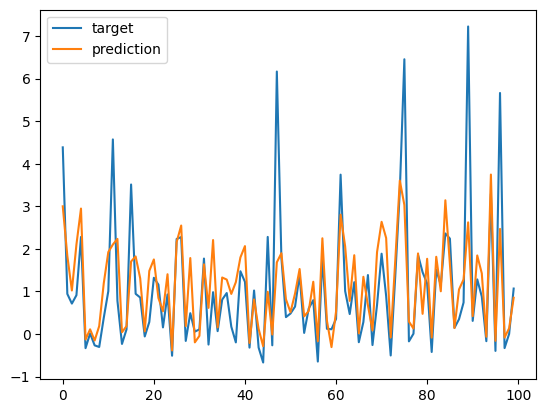

In [23]:
plt.figure()
plt.plot(target[0][:][i][:100].to("cpu"),label="target")
plt.plot(yhat[0][:][i][:100].to("cpu"),label="prediction")
plt.legend()
plt.show()
